In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.sampling import Sampler

In [4]:
ds = 4
da = 2

tau = 0.1
gamma = 0.9
alpha = 1.0

b = -1

In [5]:
G = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double()

def primal_reward_fn(env, a):
    return ((env.s @ G) * env.s).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    #return 100 * (s[:, 0].sign().clip(max=0.0) + s[:, 1].sign().clip(max=0.0)).clip(min=-1)
    return 100 * (env.s[:, 0].clip(max=1.0) + env.s[:, 1].clip(max=1.0) - 2)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[1, 1, -10, -10],
            high= [10, 10, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [6]:
epochs = 200
n_pe = 100
n_rho = 100_000
n_roll = 100

gamma = 0.9
eta = 0.1

env = RobotWorld(range_pos=[1., 10.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

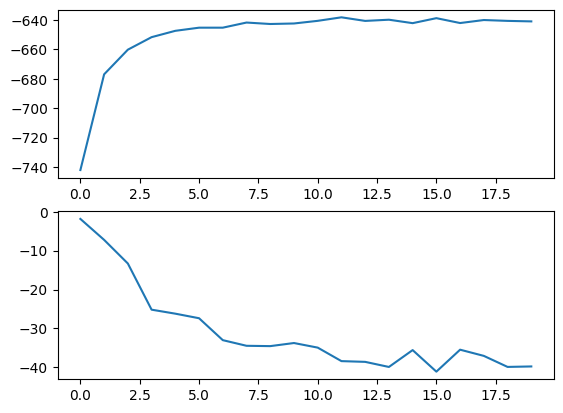

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

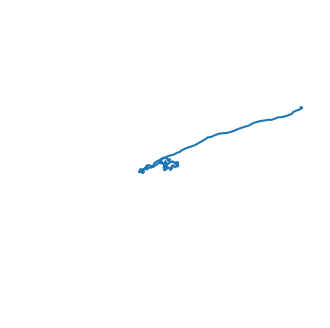

In [93]:
T = 200
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axis('off')
plt.show()

In [8]:
epochs = 1000
n_pe = 100
n_rho = 100_000
n_roll = 200

gamma = 0.95

eta = 0.001

b = - 5.0
# b -2 and eta 0.001

env = RobotWorld(range_pos=[1., 10.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

In [253]:
epochs = 10_000
n_pe = 100
n_rho = 100_000
n_roll = 100

gamma = 0.9

eta = 0.0005

b = - 0.5
# b -2 and eta 0.001

env = RobotWorld(range_pos=[1., 10.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

KeyboardInterrupt: 

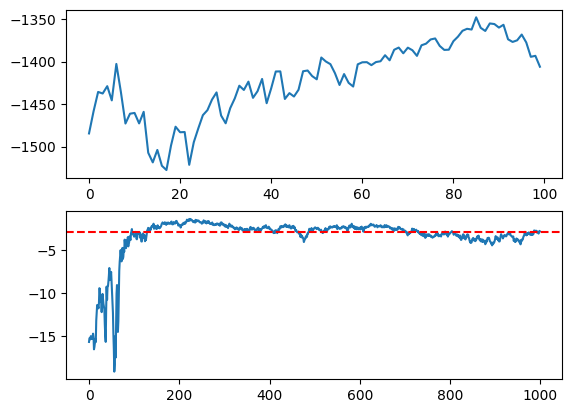

In [494]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

In [28]:
np.save('../results/obs_primal.npy', losses_primal)
np.save('../results/obs_dual.npy', losses_dual)

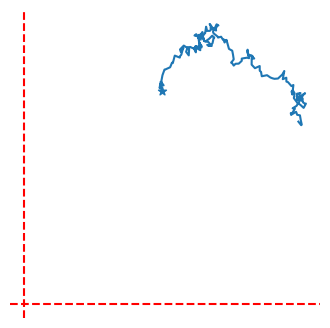

In [539]:
T = 200
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.axis('off')
plt.show()